# CS4270 Gaze Lab - Analysis of gaze patterns

This notebook will show you how to analyze gaze data using video fragments of conversations obtained from the IFADV corpus.
The raw ELAN files are already processed into JSON files for you to work with.

All necessary data processing steps are already implemented for you, such that you can focus on analyzing the data.
You will need the following packages installed in your Jupyter environment: tqdm, matplotlib, scipy, numpy.


## 1. Data processing

Everything in this section is already implemented.
You need to thoroughly understand what happens here in order to be able to make an analysis.
It may also be useful to add helper functions in this section to easen your analysis.

### 1.1 Configure Global Variables


In [5]:
# Configure target files used in the analysis.
TARGET_FILES = ['data/elan_export_dva1a_with_gaze.json', 'data/elan_export_dva6h_with_gaze.json', 
                'data/elan_export_dva4c_with_gaze.json', 'data/elan_export_dva3e_with_gaze.json',
               'data/elan_export_dva11q_with_gaze.json', 'data/elan_export_dva14w_with_gaze.json',
               'data/elan_export_dva22al_with_gaze.json']

# Configure the detection threshold used for making the turn-taking gaze pattern plots. The default value used is from the paper: 
# Oertel, Catharine, et al. "Gaze patterns in turn-taking." 
# Thirteenth annual conference of the international speech communication association. 2012.
DETECTION_THRESHOLD_MS = 130

# Configure whether to allow pre-coded prints that can make debugging easier.
ALLOW_DEBUG_PRINT = False

# Configure the random seed that is used throughout the program but more specifically for inserting artificial speakers.
RANDOM_SEED = 0

# Configure whether consecutive speaking blocks should be connected to one speaking block. 
CONNECT_SPEAKING_BLOCKS = True

# Give the appropiate speakers/gaze labels associated with the TARGET_FILES. For example, the first file in 
# the array TARGET_FILES corresponds to the first item in the SPEAKER_LABELS 
# and GAZE_LABELS array. The labels are used in order
# to identify the tiers/participants from ELAN.
SPEAKER_LABELS = [
    ["spreker1 [v] (TIE0)", "spreker2 [v] (TIE2)"],
    ["spreker1 [v] (TIE0)", "spreker2 [v] (TIE1)"],
    ["spreker1 [v] (TIE0)", "spreker2 [v] (TIE2)"],
    ["spreker1 [v] (TIE0)", "spreker2 [v] (TIE2)"],
    ["spreker1 [v] (TIE0)", "spreker2 [v] (TIE2)"],
    ["spreker1 [v] (TIE0)", "spreker2 [v] (TIE2)"],
    ["spreker1 [v] (TIE0)", "spreker2 [v] (TIE2)"]
]

GAZE_LABELS = [
    ["kijkrichting spreker1 [v] (TIE1)", "kijkrichting spreker2 [v] (TIE3)"],
    ["kijkrichting spreker1 [v] (TIE2)", "kijkrichting spreker2 [v] (TIE3)"],
    ["kijkrichting spreker1 [v] (TIE1)", "kijkrichting spreker2 [v] (TIE3)"],
    ["kijkrichting spreker1 [v] (TIE1)", "kijkrichting spreker2 [v] (TIE3)"],
    ["kijkrichting spreker1 [v] (TIE1)", "kijkrichting spreker2 [v] (TIE3)"],
    ["kijkrichting spreker1 [v] (TIE1)", "kijkrichting spreker2 [v] (TIE3)"],
    ["kijkrichting spreker1 [v] (TIE1)", "kijkrichting spreker2 [v] (TIE3)"]
]

### 1.2 Extract ELAN JSON files

In [6]:
import json
import sys
import random
from itertools import chain


class ELANDataProcessing:
    """Responsible for extracting information from ELAN exported json files."""
    
    def __init__(self, file, artificial_speakers=[], speakers=[], gazes=[], seed=RANDOM_SEED,
                speaking_blocks=[]):
        """The file indicates the file used, the artificial speakers are 
        speakers added to increase the number of speakers artificially 
        (a list of string should represents their names), speakers parameter 
        is used to provide the speaker labels, gazes parameter is used to provide the gaze labels,
        and the seed indicates which seed is used for random values."""
        
        self.speakers = speakers
        self.gazes = gazes
        
        self.gaze_blocks_by_speaker = {}
        
        for gaze_speaker in gazes:
            self.gaze_blocks_by_speaker[gaze_speaker] = []
        
        self.speaking_blocks = []
        self.ranges = {}
        self.gaze_map = {}
        
        random.seed(seed)
        
        if len(speaking_blocks) == 0:
            target = open(file)
            self.data = json.load(target)
            target.close()
        
            self.__extract_speaking_and_gaze_blocks()
        else:
            self.speaking_blocks = speaking_blocks
        
        for speaker in artificial_speakers:
            self.__add_artificial_speaker(speaker)
        
        # Sorting by start time allows us to detect overlaps quicker and results
        # in an array that is representative of when the utterances were said. That is,
        # things said earlier appear early in the array and things said later appear
        # later in the array.
        self.speaking_blocks = sorted(self.speaking_blocks, 
                                      key=lambda b: b['time']['start'])
        

    def get_gaze_type_at_position(self, position, speaker_gaze):
        """Get gaze type for certain speaker at certain position ms in time."""
        return self.gaze_map[speaker_gaze].get(position)
        

    def get_speaking_blocks(self):
        """Returns all the ordered (by start time) speaking blocks."""
        return self.speaking_blocks
    

    def get_gaze_blocks_by_speaker(self):
        """Returns all the ordered (by start time) gaze blocks."""
        return self.gaze_blocks_by_speaker
    
    
    def get_total_conversation_length(self):
        """Return the length of the conversation."""
        
        max_end = -1
        
        for block in self.speaking_blocks:
            max_end = max(max_end, block['time']['end'])
        
        return max_end

    
    def get_speakers(self):
        """Return the speakers."""
        return self.speakers
    
    
    def get_gazes(self):
        """Return the gaze labels."""
        return self.gazes
        

    def __time_parser(self, target_selector_value):
        """Parses the time format given in the target selector value 
        JSON object and returns a simple object. The time values are original floats 
        representing seconds, they are converted to milliseconds for ease."""
        raw_values = target_selector_value[2:].split(",")

        return {
            'start': int(float(raw_values[0])*1000),
            'end': int(float(raw_values[1])*1000)
        }


    def __add_artificial_speaker(self, name):
        """Adds an artificial speakers which is just a modified 
        version of the first speaker where the start and end times are slighly 
        changed with a random number."""
        print(f'WARNING: Artificial speaker {name} uses the first data value in "contains" array of the ELAN file.\nSo make sure that is not gaze data instead of speaker data.')
        for item in self.data['contains'][0]['first']['items']:
            parsed_data = self.__time_parser(item['target'][0]['selector']['value'])

            block = {
                'text': item['body']['value'],
                'time': {
                    'start': parsed_data['start'] + random.randint(1000,2000),
                    'end': parsed_data['end'] + random.randint(1000,2000)
                },
                'speaker': name
            }

            self.speaking_blocks.append(block)

            
    def __extract_speaking_and_gaze_blocks(self):
        """Extract speaking blocks from the original data. These blocks represent an utterance 
        and contain a id, text said, start/end time, and the speaker label."""
        last_index = -1
        
        for gazer in self.gazes:
            self.ranges[gazer] = {
                'g': (),
                'x': (),
            }
        
        for speaker in self.data['contains']:
            if speaker['label'] in self.speakers:
                for item in speaker['first']['items']:
                    block = {
                        'id': item['id'].split(':')[2],
                        'text': item['body']['value'],
                        'time': self.__time_parser(item['target'][0]['selector']['value']),
                        'speaker': speaker['label']
                    }
                    
                    if CONNECT_SPEAKING_BLOCKS:
                        if last_index == -1:
                            self.speaking_blocks.append(block)
                            last_index += 1
                            continue

                        last_block = self.speaking_blocks[last_index]

                        if last_block['time']['end'] == block['time']['start'] and \
                            last_block['speaker'] == speaker['label']:
                            self.speaking_blocks[last_index]['text'] += (" " + block['text'])
                            self.speaking_blocks[last_index]['time']['end'] = block['time']['end']
                        else:
                            self.speaking_blocks.append(block)
                            last_index += 1
                    else:
                        self.speaking_blocks.append(block)
            elif speaker['label'] in self.gazes:
                for item in speaker['first']['items']:
                    block = {
                        'id': item['id'].split(':')[2],
                        'label': item['body']['value'].lower(),
                        'time': self.__time_parser(item['target'][0]['selector']['value']),
                        'speaker_gaze': speaker['label']
                    }
                    
                    # Sometimes gaze types are not 'x' or 'g', then they will automatically become 'x'.
                    if block['label'] != 'x' and block['label'] != 'g':
                        block['label'] = 'x'
 
                    if block['label'] == 'x':
                        self.ranges[speaker['label']]['x'] += ((block['time']['start'], block['time']['end']),)
                    else:
                        self.ranges[speaker['label']]['g'] += ((block['time']['start'], block['time']['end']),)

                    self.gaze_blocks_by_speaker[speaker['label']].append(block)
                    
        for gazer in self.gazes:
            # Source: https://stackoverflow.com/questions/6053974/python-efficiently-check-if-integer-is-within-many-ranges
            self.gaze_map[gazer] = dict((k,v) for v in self.ranges[gazer] for k in chain(*map(range, *zip(*self.ranges[gazer][v]))))
    

    def get_overlaps(self):
        """Determine all overlaps in pairs. When there are many overlaps 
        it can be deduced which blocks are overlapping with each other."""
        overlaps = []
        last_item = self.speaking_blocks[0]
        overlap_id = 1

        for item in self.speaking_blocks:
            
            if last_item['speaker'] == item['speaker']:
                last_item = item
                continue

            if last_item['time']['end'] > item['time']['start'] and last_item['speaker'] != item['speaker']:
                overlaps.append({
                    'id': overlap_id,
                    'overlap_time': min(last_item['time']['end'], item['time']['end']) - item['time']['start'],
                    'last': last_item,
                    'next': item
                })

                overlap_id += 1
                
            if last_item['time']['end'] < item['time']['end']:
                last_item = item
            
        
        return overlaps
    
    
    def get_silence_blocks(self):
        """Determine moments of silence in a conversation and who started/ended them."""
        silence_start = 0
        silence_blocks = []
        silence_starter = None
        
        for item in self.speaking_blocks:
            
            if item['time']['start'] <= silence_start:
                if item['time']['end'] > silence_start:
                    silence_starter = item['speaker']
                    
                silence_start = max(item['time']['end'], silence_start)
                
                continue
            
            if item['time']['start'] >= silence_start:
                if ALLOW_DEBUG_PRINT:
                    print(f"Silence from {silence_start}ms to {item['time']['start']}ms. Starter: {silence_starter}, Ender: {item['speaker']}")
                
                silence_blocks.append({
                    'start': silence_start,
                    'end': item['time']['start'],
                    'duration': item['time']['start'] - silence_start,
                    'starter': silence_starter,
                    'ender': item['speaker'],
                    'ender_data': item
                })
                    
                silence_start = item['time']['end']
                silence_starter = item['speaker']     
            
                
        return silence_blocks

# This here is just as an example and to be used for the sliding window code.
edp = ELANDataProcessing(file=TARGET_FILES[0], speakers=SPEAKER_LABELS[0], 
                         gazes=GAZE_LABELS[0])
speaking_blocks = edp.get_speaking_blocks()
overlap_pairs = edp.get_overlaps()
total_length = edp.get_total_conversation_length()
gaze_blocks_by_speaker = edp.get_gaze_blocks_by_speaker()
silence_blocks = edp.get_silence_blocks()

### 1.3 Turn-transition types and gaze

In [7]:
class TurnAndGazeAnalysis:
    """Responsible for detecting turn-transition types and 
    for gaze analysis at midpoints."""
    
    def __init__(self, edp):
        """We only need an ELANDataProcessing instance for our computations."""
        self.overlap_pairs = edp.get_overlaps()
        self.silence_blocks = edp.get_silence_blocks()
        self.speakers = edp.get_speakers()
        self.gazes = edp.get_gazes()
        self.edp = edp
        self.inventory = []
        
        self.__detect_overlap_turn_transitions()
        self.__detect_silence_turn_transitions()

        
    def __detect_overlap_turn_transitions(self):
        """Determine all turn transitions with an overlap."""
        for overlap in self.overlap_pairs:
            overlap_start = overlap['next']['time']['start']
            overlap_end =  overlap['next']['time']['start'] + overlap['overlap_time']

            if overlap['overlap_time'] >= DETECTION_THRESHOLD_MS:
                if overlap['last']['time']['end'] < overlap['next']['time']['end']:
                    #print('a. Overlap with Speaker change')
                    self.inventory.append({
                        'type': 'OV_with_SC',
                        'start': overlap_start,
                        'end': overlap_end,
                        'time_point': overlap_start,
                        'original_speaker': overlap['last']['speaker'],
                        'incoming_speaker': overlap['next']['speaker']
                    })

                if overlap['last']['time']['end'] > overlap['next']['time']['end']:
                    #print('b. Overlap without Speaker change')
                    self.inventory.append({
                        'type': 'OV_without_SC',
                        'start': overlap_start,
                        'end': overlap_end,
                        'time_point': overlap_start,
                        'original_speaker': overlap['last']['speaker'],
                        'incoming_speaker': overlap['next']['speaker']
                    })

            if overlap['last']['time']['end'] > overlap['next']['time']['end'] \
                and overlap['overlap_time'] < DETECTION_THRESHOLD_MS:
                #print('e. Overlap with backchannel')
                self.inventory.append({
                    'type': 'OV_with_BACK',
                    'start': overlap_start,
                    'end': overlap_end,
                    'time_point': overlap_start,
                    'original_speaker': overlap['last']['speaker'],
                    'incoming_speaker': overlap['next']['speaker']
                })
            elif overlap['overlap_time'] < DETECTION_THRESHOLD_MS:
                #print('g1. No-overlap')
                self.inventory.append({
                    'type': 'No_GAP_No_OV',
                    'start': overlap_start,
                    'end': overlap_end,
                    'time_point': overlap_start,
                    'original_speaker': overlap['last']['speaker'],
                    'incoming_speaker': overlap['next']['speaker']
                })


    def __detect_silence_turn_transitions(self):
        """Determine all turn transitions with a silence."""
        for silence in self.silence_blocks:
            if silence['starter'] != silence['ender'] \
                and (silence['ender_data']['time']['end'] - \
                     silence['ender_data']['time']['start']) < DETECTION_THRESHOLD_MS:
                #print('f. Silence with backchannel')
                self.inventory.append({
                    'type': 'SIL_with_BACK',
                    'start': silence['start'],
                    'end': silence['end'],
                    'time_point': silence['end'],
                    'original_speaker': silence['starter'],
                    'incoming_speaker': silence['ender']
                })

            if silence['duration'] >= DETECTION_THRESHOLD_MS:
                if silence['starter'] == silence['ender']:
                    #print('d. Silence without speaker change')
                    
                    # This only applies when you have two speakers.
                    if silence['ender'] == self.speakers[0]:
                        silence['ender'] = self.speakers[1]
                    else:
                        silence['ender']= self.speakers[0]
                    
                    self.inventory.append({
                        'type': 'SIL_without_SC',
                        'start': silence['start'],
                        'end': silence['end'],
                        'time_point': silence['end'],
                        'original_speaker': silence['starter'],
                        'incoming_speaker': silence['ender']
                    })
                else:
                    #print('c. Silence with speaker change')
                    self.inventory.append({
                        'type': 'SIL_with_SC',
                        'start': silence['start'],
                        'end': silence['end'],
                        'time_point': silence['end'],
                        'original_speaker': silence['starter'],
                        'incoming_speaker': silence['ender']
                    })
            else:
                #print('g2. No-gap')
                self.inventory.append({
                    'type': 'No_GAP_No_OV',
                    'start': silence['start'],
                    'end': silence['end'],
                    'time_point': silence['end'],
                    'original_speaker': silence['starter'],
                    'incoming_speaker': silence['ender']
                })

                    
    def __opposite_gaze(self, value):
        """Negate gaze type."""
        if value == 'g':
            return 'x'
        else:
            return 'g'
        

    def get_gaze_rows(self, midpoint, original_speaker, incoming_speaker):
        """Construct gaze rows given midpoint and the original/incoming speaker."""
        left = midpoint - 3000
        right = midpoint + 3000

        if left < 0 or right > total_length:
            return None, None

        gaze_index_og = self.speakers.index(original_speaker)
        gaze_index_in = self.speakers.index(incoming_speaker)

        row_og = ""
        row_in = ""
        last_og = None
        last_in = None

        for i in range(left, right, 10):
            original = self.edp.get_gaze_type_at_position(i, self.gazes[gaze_index_og])
            incoming = self.edp.get_gaze_type_at_position(i, self.gazes[gaze_index_in])

            # Sometimes we can get None as the gaze type if gaze position
            # does not fall in an gaze interval (block). When this occurs the opposite value of
            # the last gaze type will be used because the missing interval likely occurs
            # at a gaze type switch moment (e.g. going from g to x). 
            if not original:
                original = self.__opposite_gaze(last_og)

            if not incoming:
                incoming = self.__opposite_gaze(last_in)

            row_og += original
            row_in += incoming

        return row_og, row_in

###  1.4 Collect data from conversations


In [153]:
import tqdm

plot_data = {
    'OV_with_SC': {
        'incoming': [],
        'original': [],
        'total': 0
    },
    'OV_without_SC': {
        'incoming': [],
        'original': [],
        'total': 0
    },
    'OV_with_BACK': {
        'incoming': [],
        'original': [],
        'total': 0
    },
    'SIL_with_BACK': {
        'incoming': [],
        'original': [],
        'total': 0
    },
    'SIL_without_SC': {
        'incoming': [],
        'original': [],
        'total': 0
    },
    'SIL_with_SC': {
        'incoming': [],
        'original': [],
        'total': 0
    },
    'No_GAP_No_OV': {
        'incoming': [],
        'original': [],
        'total': 0
    }
}

def fill_plot_data(scenario: str, plot_data):
    if plot_data[scenario]['original'] == [] or plot_data[scenario]['incoming'] == []:
            plot_data[scenario]['original'] = [1 if g == 'g' else 0 for g in gaze_rows[0]]
            plot_data[scenario]['incoming'] = [1 if g == 'g' else 0 for g in gaze_rows[0]]
            plot_data[scenario]['total'] = 1
    else:
        plot_data[scenario]['original'] = [1 + g_tot if g_new == 'g' else g_tot for g_new, g_tot in zip(gaze_rows[0], plot_data[scenario]['original'])]
        plot_data[scenario]['incoming'] = [1 + g_tot if g_new == 'g' else g_tot for g_new, g_tot in zip(gaze_rows[1], plot_data[scenario]['incoming'])]
        plot_data[scenario]['total'] += 1
            

for i in tqdm.tqdm(range(len(TARGET_FILES))):
    edp = ELANDataProcessing(file=TARGET_FILES[i], speakers=SPEAKER_LABELS[i], 
                         gazes=GAZE_LABELS[i])
    conv = TurnAndGazeAnalysis(edp)
    
    for inv in conv.inventory:
        gaze_rows = conv.get_gaze_rows(inv['time_point'], inv['original_speaker'], inv['incoming_speaker'])
        if gaze_rows[0] is not None and gaze_rows[1] is not None:
            fill_plot_data(inv['type'], plot_data)

        
for k in plot_data.keys():
    for sp in ['incoming', 'original']:
        plot_data[k][sp] = [x / plot_data[k]['total'] for x in plot_data[k][sp]]


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


## 2. Data analysis

## 2.1 Research questions

If we want to know what should be analysed, we should know what questions we want to answer first.
Try to come up with some research questions that will help us create a more realistic virtual starship receptionist in the end.

_What happens to the gaze of someone who is interrupted (when the space receptionist's script is interrupted)?_

_What happens to the gaze of someone who is about to take the turn (when the receptionist is getting ready to respond)?_

## 2.2 Data visualisation

For each question you constructed, create one or more plots that help you answer that question.
You can find some inspiration in [Oertel, Catharine, et al. "Gaze patterns in turn-taking."](https://www.speech.kth.se/prod/publications/files/3744.pdf).

In [68]:
import matplotlib.pyplot as plt

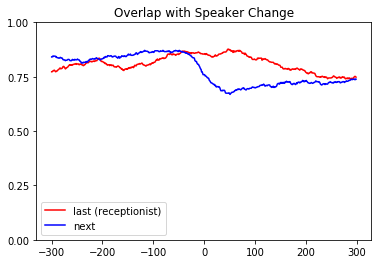

In [159]:
X = [x for x in range(-300, 300)]
Y = plot_data['OV_with_SC']['original']

plt.plot(X, Y, 'r', label='last (receptionist)')
plt.legend()

X = [x for x in range(-300, 300)]
Y = plot_data['OV_with_SC']['incoming']

plt.plot(X, Y, 'b', label='next')
plt.legend()
plt.title('Overlap with Speaker Change')

plt.yticks([0, .25, .50, .75, 1])
plt.show()

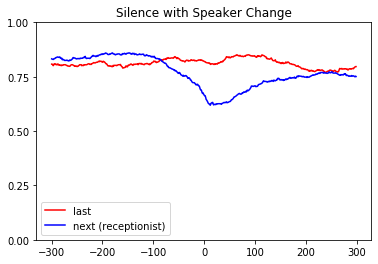

In [158]:
X = [x for x in range(-300, 300)]
Y = plot_data['SIL_with_SC']['original']

plt.plot(X, Y, 'r', label='last')
plt.legend()

X = [x for x in range(-300, 300)]
Y = plot_data['SIL_with_SC']['incoming']

plt.plot(X, Y, 'b', label='next (receptionist)')
plt.legend()
plt.title('Silence with Speaker Change')

plt.yticks([0, .25, .50, .75, 1])
plt.show()

## 2.3 Modelling gaze

If all went well, you should have obtained some distributions of gaze over time in different situations.
In this section, we will think about how we can use this information to model the gaze of our virtual receptionist.
This requires you to first come up with variables that you will need to implement, e.g. the amount of seconds after a person starts talking until the direction of gaze changes.
For simplicity, you can model these variables using Gaussian distributions. (Of course you are allowed to make as complicated a model as you want.)

In [ ]:
# Your code here